In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from tqdm import tqdm; tqdm.pandas();
from src.dag import grn
import os
import pickle

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

%matplotlib inline

# Simulations

In [2]:
# load data from previous figure
n_sims = 2000
n_genes = 1000

if os.path.exists('figdata/fig4_grns.parquet') and os.path.exists('figdata/fig4_grns.list.pkl'):
    grns = pd.read_parquet('figdata/fig4_grns.parquet')
    G_s = pickle.load(open('figdata/fig4_grns.list.pkl', 'rb'))
else:
    grns = pd.DataFrame({
        'n': n_genes,
        'r': np.random.uniform(3, 12, size=n_sims),
        'k': np.random.randint(2, 50, size=n_sims),
        'gamma': np.random.uniform(0.1, 1, size=n_sims),
        'p_up': np.random.uniform(0, 1, size=n_sims),
        'hier': np.random.choice([False, True], size=n_sims)
    })
    grns['m'] = [np.random.uniform(1./k, 0.9) for k in grns['k']]

    G_s = [grn().add_structure(method='ppm',
                              n_genes = row.n, 
                              n_groups = row.k,
                              r = row.r,
                              m = row.m,
                              hierarchy = row.hier
               ).add_expression_parameters(
                              sign = np.random.choice([-1, 1], p=[1 - row.p_up, row.p_up], size=(row.n, 1)),
                              weight = row.gamma
               ).compute_h2() 
           for _,row in tqdm(grns.iterrows())
    ]

# compute leading squared trans eqtl effect sizes (no selection) 
lead_tbetas = list(map(lambda X: (X - np.diag(np.diag(X))).max(axis=0), [0.1 * (G.L ** 2) for G in tqdm(G_s)]))

# recompute variances under strong stabilizing selection
if os.path.exists('figdata/fig4_grns.stabsel.list.pkl'):
    G_s = pickle.load(open('figdata/fig4_grns.stabsel.list.pkl', 'rb'))
    V_cis_s = [G.V_cis for G in G_s]
else:
    V_cis_s = list(map(lambda x: len(x) * x / sum(x), [1./(G.L ** 2).sum(axis=1) for G in G_s]))
    G_s = [G.compute_h2(V_cis) for G,V_cis in tqdm(zip(G_s, V_cis_s))]
    pickle.dump(G_s, open('figdata/fig4_grns.stabsel.list.pkl', 'wb'))

# compute leading squared trans eqtl effect sizes (strong stabilizing selection)
lead_tbetas_s = list(map(lambda X: (X - np.diag(np.diag(X))).max(axis=0), [0.1 * (G.L ** 2) for G in tqdm(G_s)]))

# append stuff
grns['Selected ' + r'$V_{cis}/V_{tot}$'] = [G.cish2 for G in G_s]
grns['Selected Median '+r'$V_{cis}/V_{tot}$'] = grns['Selected '+r'$V_{cis}/V_{tot}$'].apply(np.median)

display(grns.head(), len(G_s))

100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:53<00:00, 17.62it/s]


,n,r,k,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$,Selected $V_{cis}/V_{tot}$,Selected Median $V_{cis}/V_{tot}$
0,1000,10.379403,25,0.168372,0.225500,False,0.526280,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.767452,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.790889
1,1000,4.152230,31,0.371429,0.285406,False,0.804861,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.615307,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.692090
2,1000,7.053620,30,0.492399,0.687883,False,0.470086,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.673...",0.180792,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.526...",0.439814
3,1000,4.724047,10,0.084264,0.544881,False,0.715078,"[1.0, 1.0, 1.0, 0.9929497079691328, 1.0, 1.0, ...",0.971471,"[1.0, 1.0, 1.0, 0.992849575033537, 1.0, 1.0, 1...",0.971736
4,1000,9.696025,11,0.087777,0.327447,True,0.881424,"[1.0, 1.0, 1.0, 0.9923540468731044, 0.99235404...",0.934612,"[1.0, 1.0, 1.0, 0.9924964232340456, 0.99205694...",0.936990


2000

# Figure 5

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


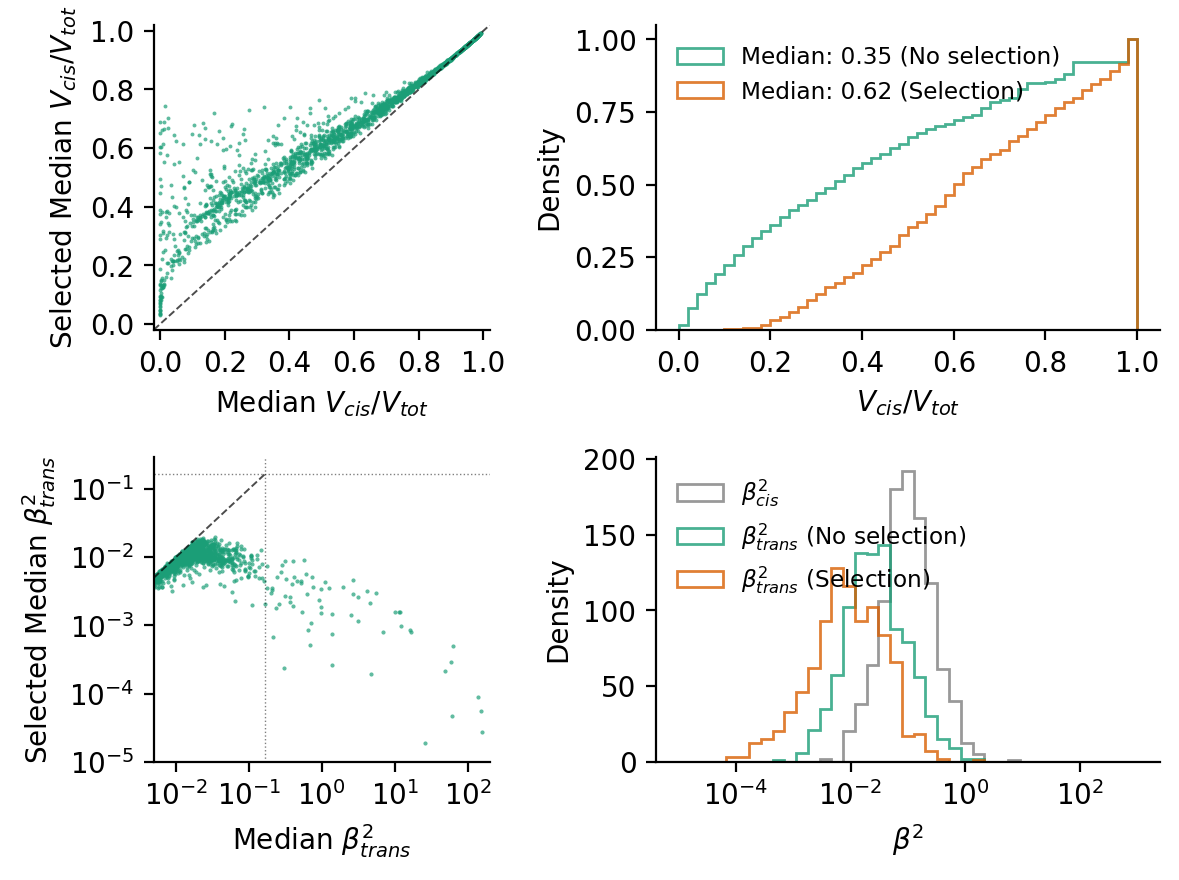

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(6, 4.5), width_ratios=(1, 1.5), dpi=200)


# transformed distribution of cis heritability fractions and leading trans-effects
V_cis = np.random.lognormal(np.log(0.1), 1, size=(n_genes,))
ax[1,1].hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-5, 1e3, 40),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

for g_ix in [190]:
    G = G_s[g_ix]
    
    for ix,V_in in enumerate([np.ones(G.n), V_cis_s[g_ix]]):
        G.compute_h2(V_in);
        V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

        ax[0,1].hist(G.cish2,
                     histtype='step',
                     cumulative=True,
                     density=True,
                     bins=np.linspace(0, 1, 51),
                     label='Median: {0:.2f} ({1}election)'.format(np.median(G.cish2), ['No s','S'][ix]),
                     alpha=0.8
                    );
        
        ax[1,1].hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
                      histtype='step', 
                      bins=np.geomspace(1e-5, 1e3, 40),
                      label=r'$\beta^2_{trans}$' + ' ({0}election)'.format(['No s','S'][ix]),
                      alpha=0.8
                     );   
        
    ax[0,1].legend(fontsize='small', frameon=False);
    ax[0,1].set_xlabel(r'$V_{cis}/V_{tot}$');
    ax[0,1].set_ylabel('Density');
    
    ax[1,1].legend(fontsize='small', frameon=False, loc='upper left');
    ax[1,1].set_xscale('log');
    ax[1,1].set_xlabel(r'$\beta^2$'); 
    ax[1,1].set_ylabel('Density');


# effects of selection on median cis-heritability
sns.scatterplot(
    data = grns,
    x = 'Median '+r'$V_{cis}/V_{tot}$',
    y = 'Selected Median '+r'$V_{cis}/V_{tot}$',
    ax = ax[0,0],
    marker = '.', 
    s = 8,
    alpha = 0.7,
    linewidth=0
)

#ax[0,0].set_xlabel('' + r'$V_{cis}/V_{tot}$' + ', none');
#ax[0,0].set_ylabel('' + r'$V_{cis}/V_{tot}$' + ', stabilizing');
ax[0,0].legend([], fontsize='x-small', frameon=False);

lim = [-0.02, 1.02]
ax[0,0].plot(lim, lim, 'k--', linewidth=0.7, alpha=0.7);
ax[0,0].set_xticks(np.linspace(0, 1, 6));
ax[0,0].set_yticks(np.linspace(0, 1, 6));
ax[0,0].set_xlim(*lim); 
ax[0,0].set_ylim(*lim); 


# effect of selection on leading trans-eqtl effect size
ax[1,0].plot([np.median(ltb) for ltb in lead_tbetas],
             [np.median(ltb) for ltb in lead_tbetas_s], 
             '.',
             ms = 1,
             alpha = 0.7
            );
ax[1,0].set_xlabel('Median ' + r'$\beta^2_{trans}$' + '');
ax[1,0].set_ylabel('Selected Median ' + r'$\beta^2_{trans}$' + '');
ax[1,0].loglog();
ax[1,0].set_xlim(5e-3, 2e2);
ax[1,0].set_xticks(np.geomspace(1e-2, 1e2, 5));
ax[1,0].set_ylim(5e-5, 3e-1);
ax[1,0].set_yticks(np.geomspace(1e-5, 1e-1, 5));

ax[1,0].plot([5e-3, 1.66e-1], [5e-3, 1.66e-1], 'k--', linewidth=0.7, alpha=0.7);
ax[1,0].axhline(1.66e-1, color='k', linestyle=':', linewidth=0.5, alpha=0.5);
ax[1,0].axvline(1.66e-1, color='k', linestyle=':', linewidth=0.5, alpha=0.5);

sns.despine();
fig.tight_layout();

# Supplement

## Parameter effects

Note $k$ has no effect and $m$ is only significant with hierarchy.

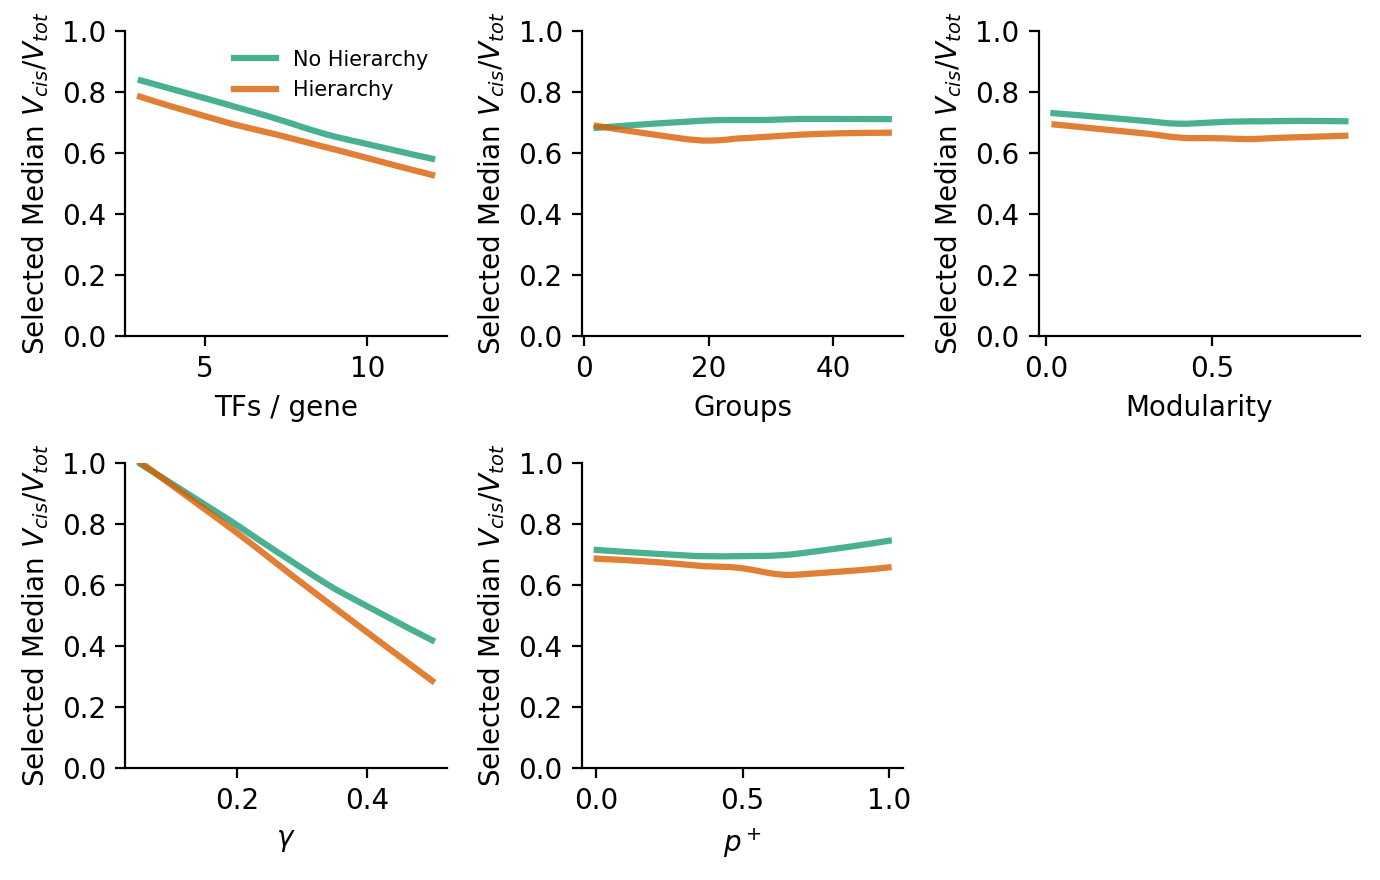

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.5), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['r','k','m','gamma','p_up',''],
                                ['TFs / gene', 'Groups', 'Modularity', r'$\gamma$', r'$p^+$','']):
    ax = axs[ix, iy]
    if not par: 
        ax.axis('off');
        continue
    for i, b in enumerate([0,1]):
        sns.regplot(data = grns.loc[grns['hier']==b], 
                    x = par, 
                    y = 'Selected Median '+r'$V_{cis}/V_{tot}$', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = True,
                    scatter = True,
                    line_kws = dict(alpha=0.8, label=('No ' if not b else '')+'Hierarchy'),
                    scatter_kws = dict(s=0, alpha=0.3, label=None),
                    #ms = 2,
                    #alpha = 0.7,
                    ax = ax
                   )
    ax.set_ylim(0, 1);
    ax.set_xlabel(label);
    if ix == 0 and iy == 0:
        ax.legend(fontsize=7.5, frameon=False, loc='upper right');

# overall figure stuff
sns.despine();
fig.tight_layout();

In [5]:
grns['y'] = grns['Selected Median '+r'$V_{cis}/V_{tot}$']

print(sm.ols('y ~ 1 + r + gamma + p_up + k + m + hier:m', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     3488.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:56:23   Log-Likelihood:                 2694.2
No. Observations:                2000   AIC:                            -5374.
Df Residuals:                    1993   BIC:                            -5335.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.3051      0.007    181.

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

## QTL effects

,n,r,k,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$,Selected $V_{cis}/V_{tot}$,Selected Median $V_{cis}/V_{tot}$,y
322,1000,7.947517,41,0.453438,0.767472,True,0.714068,"[1.0, 0.8294582974857979, 0.8013591069462959, ...",0.001661,"[1.0, 0.9975557487459926, 0.028567801655847783...",0.081376,0.081376
176,1000,7.904598,24,0.464917,0.407226,True,0.469318,"[1.0, 1.0, 0.8222683845417085, 1.0, 0.79184847...",0.075924,"[1.0, 1.0, 0.7779326558606592, 1.0, 0.80509965...",0.254172,0.254172
390,1000,7.412292,20,0.476476,0.137942,True,0.702777,"[1.0, 0.8149762400341065, 1.0, 0.8149762400341...",0.106622,"[1.0, 0.7676347946975427, 1.0, 0.6806052746530...",0.261508,0.261508
679,1000,6.908840,13,0.485516,0.550394,True,0.498757,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.809241243440415, 1...",0.090131,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.9140729710757931, ...",0.262980,0.262980


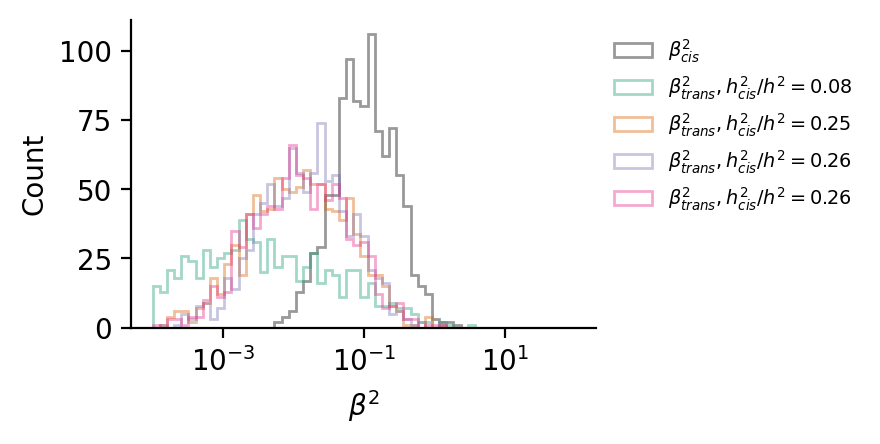

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3,2), dpi=200)

V_cis = np.random.lognormal(np.log(0.1), 1, size=(n_genes,))
ax.hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-4, 1e2, 60),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

x = grns.query('gamma < 0.6 & r < 8').sort_values('y').head(4)
display(x)

for ix in x.index:
    G = G_s[ix]
    G.compute_h2(V_cis_s[ix]);
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
             histtype='step', 
             bins=np.geomspace(1e-4, 1e2, 60),
             label=r'$\beta^2_{trans}, h^2_{cis}/h^2=$'+'{:.2f}'.format(grns.loc[ix].iloc[-1]),
             alpha=0.4
            );
    
ax.legend(fontsize='x-small', frameon=False, bbox_to_anchor=(1.0, 1.0));
ax.set_xscale('log');
ax.set_xlabel(r'$\beta^2$'); 
ax.set_ylabel('Count');
sns.despine();

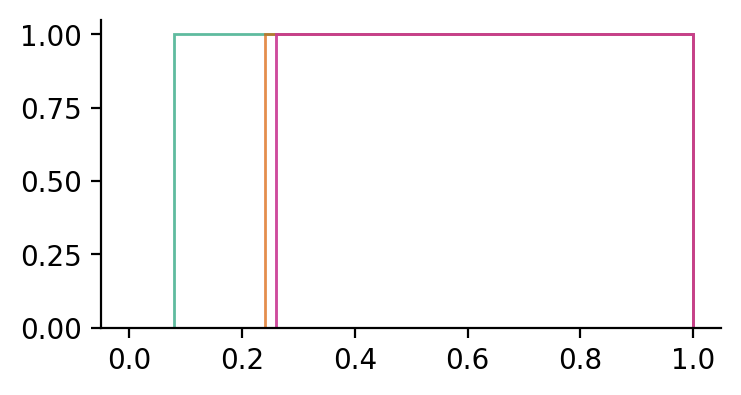

In [7]:
plt.figure(figsize=(4,2), dpi=200);
for _,row in x.iterrows():
    plt.hist(row['Selected Median '+r'$V_{cis}/V_{tot}$'], bins=np.linspace(0,1,51), cumulative=True, histtype='step', alpha=0.7);
sns.despine();

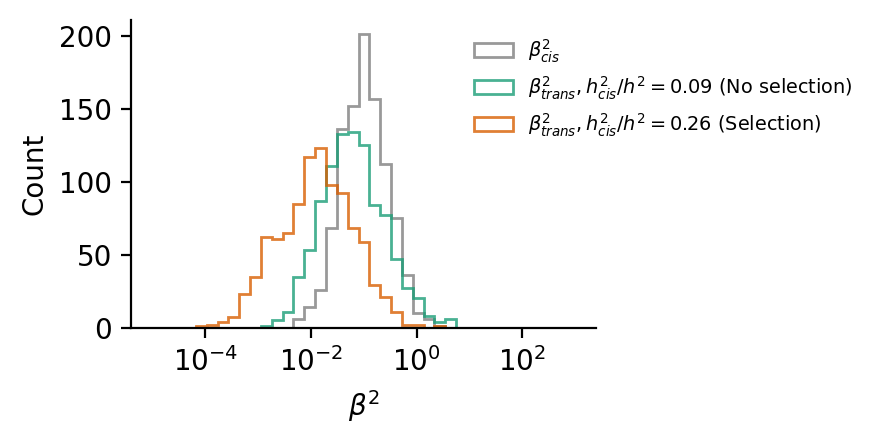

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3,2), dpi=200)

V_cis = np.random.lognormal(np.log(0.1), 1, size=(n_genes,))
ax.hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-5, 1e3, 40),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

for ix in x.index[-1:]:
    G = G_s[ix]
    
    for V_in in [np.ones(G.n), V_cis_s[ix]]:
        G.compute_h2(V_in);
        V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

        ax.hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
                 histtype='step', 
                 bins=np.geomspace(1e-5, 1e3, 40),
                 label=r'$\beta^2_{trans}, h^2_{cis}/h^2=$'+'{0:.2f} ({1}election)'.format(np.median(G.cish2), 'No s' if (V_in==1).all() else 'S'),
                 alpha=0.8
                );
    
ax.legend(fontsize='x-small', frameon=False, bbox_to_anchor=(0.7, 1.0));
ax.set_xscale('log');
ax.set_xlabel(r'$\beta^2$'); 
ax.set_ylabel('Count');
sns.despine();

/var/folders/z_/2pcm07x525lcnwmhscyx82g40000gn/T/ipykernel_10196/1866694149.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(np.clip(np.nan_to_num(np.log10(np.abs(G.L) / np.sqrt(np.abs(G.L.T @ G.L))), -3), -3, 3))
/var/folders/z_/2pcm07x525lcnwmhscyx82g40000gn/T/ipykernel_10196/1866694149.py:10: RuntimeWarning: divide by zero encountered in log10
  ax[1].imshow(np.clip(np.nan_to_num(np.log10(np.abs(G.L) / np.sqrt(np.abs(G.L.T @ G.L))), -3), -3, 3))


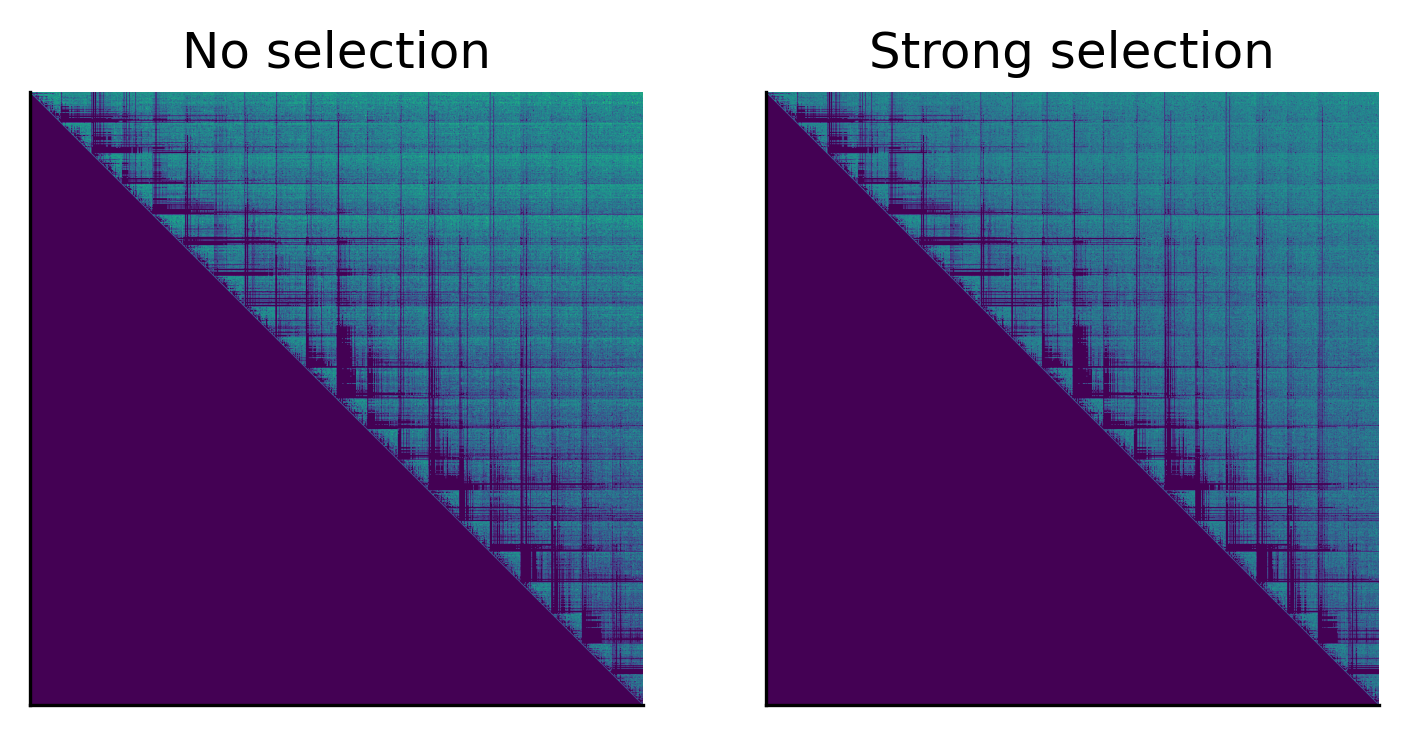

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(5.8, 12), dpi=300);

G = G_s[x.index[2]].compute_h2(np.ones(n_genes))
ax[0].imshow(np.clip(np.nan_to_num(np.log10(np.abs(G.L) / np.sqrt(np.abs(G.L.T @ G.L))), -3), -3, 3))
ax[0].set_title('No selection');
ax[0].xaxis.set_visible(False);
ax[0].yaxis.set_visible(False);

G = G_s[x.index[2]].compute_h2(V_cis_s[x.index[2]])
ax[1].imshow(np.clip(np.nan_to_num(np.log10(np.abs(G.L) / np.sqrt(np.abs(G.L.T @ G.L))), -3), -3, 3))
ax[1].set_title('Strong selection');
ax[1].xaxis.set_visible(False);
ax[1].yaxis.set_visible(False);

sns.despine();

In [10]:
grns[['r','k','gamma','p_up','hier','m']].describe()

,r,k,gamma,p_up,m
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,7.593318,25.438000,0.273006,0.485767,0.480350
std,2.593690,13.641122,0.128051,0.282713,0.240899
min,3.000907,2.000000,0.050093,0.001633,0.022839
25%,5.372644,14.000000,0.164273,0.246148,0.280910
50%,7.653652,25.000000,0.269456,0.476499,0.477545
75%,9.844658,37.000000,0.382158,0.729047,0.691150
max,11.995691,49.000000,0.499642,0.999360,0.899599


In [12]:
grns.iloc[(grns['y'] < 0.3).values & 
          (np.median(np.array(lead_tbetas_s), axis=1) < 3e-2) & 
          (grns.gamma < 0.4).values, :]

,n,r,k,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$,Selected $V_{cis}/V_{tot}$,Selected Median $V_{cis}/V_{tot}$,y
80,1000,11.034976,41,0.311959,0.820108,True,0.645339,"[1.0, 1.0, 0.8370743591188531, 0.8370743591188...",4.977580e-03,"[1.0, 1.0, 0.9861039812640899, 0.9832836818895...",0.223289,0.223289
297,1000,10.138097,49,0.397065,0.855280,True,0.692963,"[1.0, 0.8638108115912299, 0.682415861618059, 0...",1.960183e-06,"[1.0, 0.7644653996399502, 0.9673718494851506, ...",0.133146,0.133146
365,1000,9.982991,21,0.387767,0.894737,True,0.592550,"[1.0, 1.0, 1.0, 1.0, 0.7688014171431107, 0.567...",6.419064e-08,"[0.9999999999999998, 0.999999999999999, 0.9999...",0.290687,0.290687
454,1000,10.538576,33,0.329823,0.812069,True,0.841962,"[1.0, 0.9018895800076188, 0.90188958000761, 0....",7.698796e-03,"[1.0, 0.820384277618336, 0.9769218031759634, 0...",0.244530,0.244530
616,1000,11.683050,10,0.345065,0.740673,True,0.886182,"[1.0, 1.0, 1.0, 0.8935994146232871, 1.0, 0.798...",2.274066e-02,"[1.0, 1.0, 1.0, 0.9817873274031613, 1.0, 0.934...",0.208834,0.208834
853,1000,11.798226,17,0.397820,0.490754,True,0.219046,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.903361e-02,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.294487,0.294487
868,1000,10.376300,37,0.391590,0.822629,True,0.277850,"[1.0, 1.0, 1.0, 0.7652950410682297, 0.67851413...",1.824994e-02,"[1.0, 1.0, 1.0, 0.9672544845706759, 0.14774976...",0.294094,0.294094
1238,1000,11.495738,42,0.355114,0.670687,True,0.778931,"[1.0, 0.8880157052822492, 0.8756498525395235, ...",5.839200e-02,"[1.0, 0.9419664843271767, 0.8453158650829727, ...",0.244215,0.244215
1444,1000,10.769374,26,0.383044,0.984680,True,0.680835,"[0.9387364118892462, 0.9136979098771921, 0.818...",4.682239e-04,"[0.5229210603882101, 0.5842202309835063, 0.665...",0.114991,0.114991
1559,1000,9.688982,26,0.381856,0.580510,True,0.760333,"[1.0, 1.0, 0.8727421974299858, 0.8727421974299...",9.565228e-02,"[1.0, 1.0, 0.9209483846322454, 0.8071991903616...",0.283527,0.283527


In [13]:
np.median(np.array(lead_tbetas), axis=1) < 1e-1

array([ True,  True,  True, ...,  True,  True,  True])

In [14]:
np.quantile(np.quantile(np.array(lead_tbetas), q=0.5, axis=1), q=[0.001, 0.01, 0.1, 0.5])

array([0.00026041, 0.00030654, 0.00094422, 0.00886097])

In [15]:
pd.Series(np.quantile(np.array(lead_tbetas), q=0.5, axis=1)).describe()

count    2.000000e+03
mean     1.072720e+07
std      3.400877e+08
min      2.509271e-04
25%      3.076379e-03
50%      8.860966e-03
75%      2.041714e-02
max      1.200375e+10
dtype: float64

In [16]:
grns[['r','gamma','p_up','k','m','hier']].describe()

,r,gamma,p_up,k,m
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,7.593318,0.273006,0.485767,25.438000,0.480350
std,2.593690,0.128051,0.282713,13.641122,0.240899
min,3.000907,0.050093,0.001633,2.000000,0.022839
25%,5.372644,0.164273,0.246148,14.000000,0.280910
50%,7.653652,0.269456,0.476499,25.000000,0.477545
75%,9.844658,0.382158,0.729047,37.000000,0.691150
max,11.995691,0.499642,0.999360,49.000000,0.899599


In [17]:
grns.loc[(1e-2 < np.quantile(np.array(lead_tbetas), q=0.5, axis=1)) & (np.quantile(np.array(lead_tbetas), q=0.5, axis=1) < 1e-1), ['r','gamma','p_up','k','m','hier']].describe()

,r,gamma,p_up,k,m
count,821.000000,821.000000,821.000000,821.000000,821.000000
mean,7.551324,0.384558,0.482383,25.146163,0.485646
std,2.544575,0.063308,0.277656,13.601760,0.242834
min,3.000907,0.184656,0.001633,2.000000,0.023356
25%,5.325364,0.337822,0.243035,13.000000,0.291075
50%,7.660369,0.383404,0.481966,25.000000,0.485323
75%,9.677623,0.434814,0.727272,37.000000,0.703713
max,11.991694,0.499499,0.999115,49.000000,0.898381


In [18]:
grns.loc[(1e-1 < grns['y']) & (grns['y'] < 3e-1), ['r','gamma','p_up','k','m','hier']].describe()

,r,gamma,p_up,k,m
count,71.000000,71.000000,71.000000,71.000000,71.000000
mean,10.005378,0.441806,0.475981,26.056338,0.563924
std,1.377239,0.040494,0.254968,12.575358,0.208343
min,6.514896,0.311959,0.043945,4.000000,0.125537
25%,9.119864,0.419979,0.247230,16.500000,0.401528
50%,9.982991,0.445062,0.484878,26.000000,0.557461
75%,11.297770,0.475894,0.706255,37.000000,0.710245
max,11.895514,0.499642,0.984680,49.000000,0.896266


In [19]:
grns.loc[(1e-1 < grns['Median '+r'$V_{cis}/V_{tot}$']) & (grns['Median '+r'$V_{cis}/V_{tot}$'] < 3e-1), ['r','gamma','p_up','k','m','hier']].describe()

,r,gamma,p_up,k,m
count,314.000000,314.000000,314.000000,314.00000,314.000000
mean,8.846844,0.411980,0.493497,24.44586,0.468343
std,1.874032,0.051970,0.278810,13.59449,0.239097
min,4.500058,0.217387,0.002523,2.00000,0.023356
25%,7.471321,0.376094,0.253547,12.00000,0.296419
50%,8.985832,0.413326,0.491762,24.00000,0.457301
75%,10.305256,0.451760,0.736062,36.00000,0.668569
max,11.990433,0.499499,0.992229,49.00000,0.896770
